# Miniproject-DQN Notebook
### Paul Boulenger, Paul Devianne

## Part 1: Introduction


In [60]:
#We import all necessary packages
import sys

import matplotlib.pyplot as plt
from gym import spaces

"""Environment imports"""
from epidemic_env.env       import Env, Log
from epidemic_env.dynamics  import ModelDynamics, Observation
from epidemic_env.visualize import Visualize
from epidemic_env.agent     import Agent

"""Pytorch and numpy imports"""
import numpy as np
import torch
from torch import nn

""" Importing usueful functions"""
from utils import *

from tqdm import tqdm
%load_ext autoreload
%autoreload 2
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Question 1.a

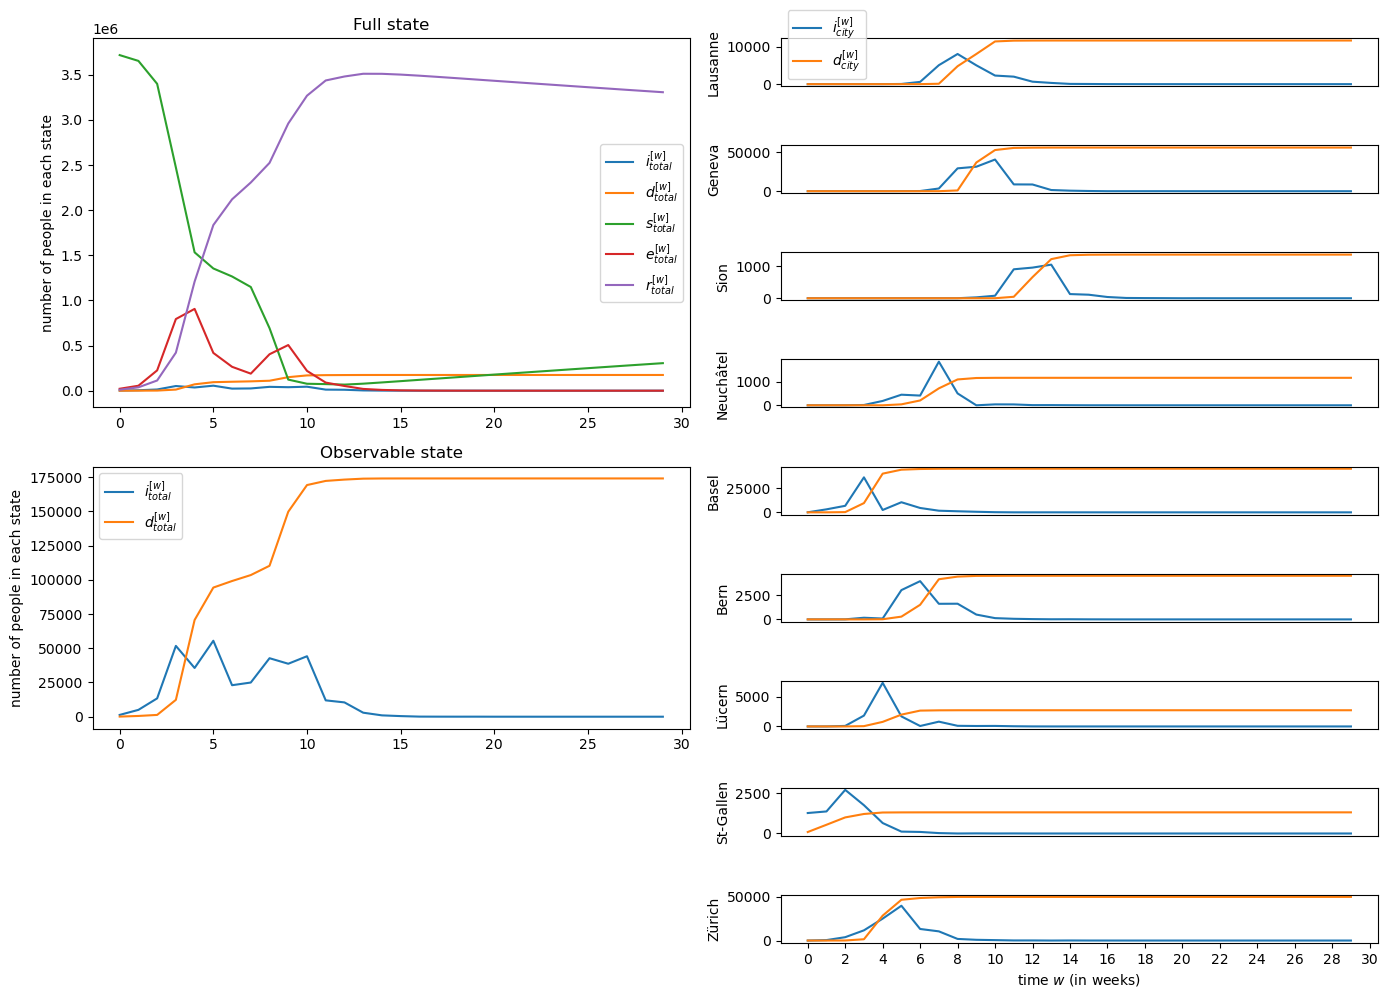

In [7]:
from epidemic_env.agent import NoAgent

"""Loading the environment"""
dyn = ModelDynamics('config/switzerland.yaml')

env = Env(dyn,
            action_preprocessor=action_preprocessor)

no_agent = NoAgent(env) #Agent that takes no action

log , _ = run_episode(no_agent, env)

plot_episode(log, dyn)

## Part 2: Professor Russo's Policy

### Question 2.a — Implement Pr. Russo’s Policy


In [8]:
from epidemic_env.agent import RussoAgent

In [9]:
def observation_preprocessor_Russo(obs: Observation, dyn:ModelDynamics):
    infected=np.array(
        [np.array(obs.city[c].infected) for c in dyn.cities])[:,6].sum() #only need to observe the number of infected
    return infected

In [10]:
dyn = ModelDynamics('config/switzerland.yaml')
russo_env = Env(dyn,
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor_Russo)

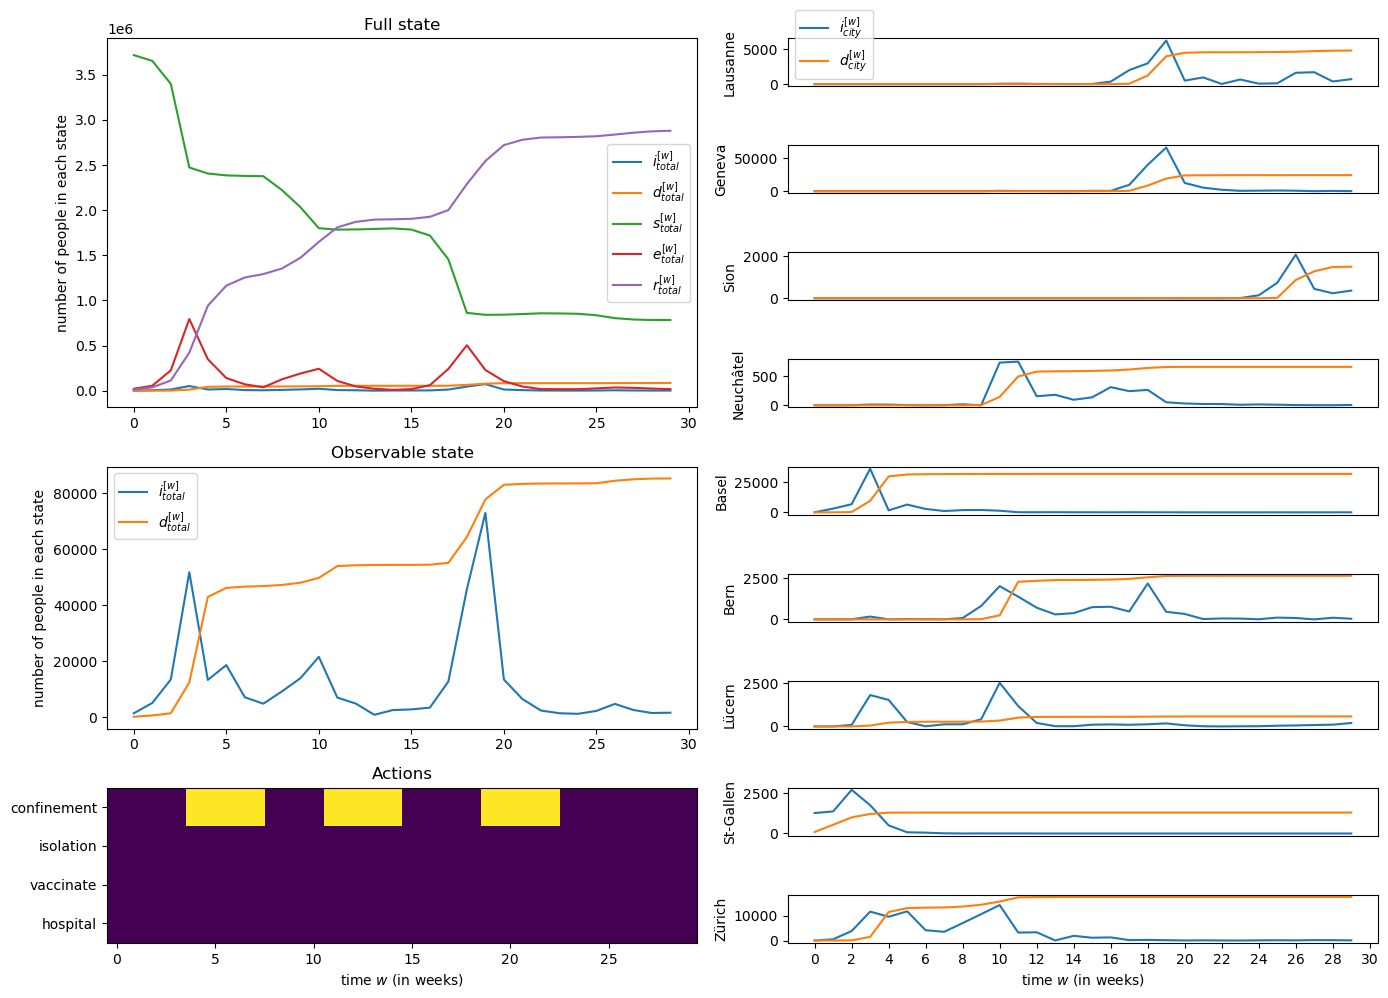

[84, -136.98130042105913, 85243]


In [11]:
obs, info = russo_env.reset(0)
russo_agent = RussoAgent(env)
log, rwds = run_episode(russo_agent, russo_env)
plot_episode(log, dyn, True)
print(extract_episode_features(log, rwds))

The professor's policy correctly confines population whenever the total population of infected is above 20'000 at the beginning of a week. The confinement are indeed four weeks long and the population is released when the total population of infected is below 20'000 at the end of the confinement. 

More specifically, three confinements are done in total. In comparison with the unmittigated case, the professor's policy reduces the total number of deaths by almost 100'000 people or 55 %. Then, we clearly the positive effect of the confinement rule on the epidemic development.

### Question 2.b — Evaluate Pr. Russo’s Policy

The seed sequence we will use is ranging from 0 to 49 changing from each episode to another. We will then average the results over the 50 episodes.

100%|██████████| 50/50 [00:39<00:00,  1.26it/s]


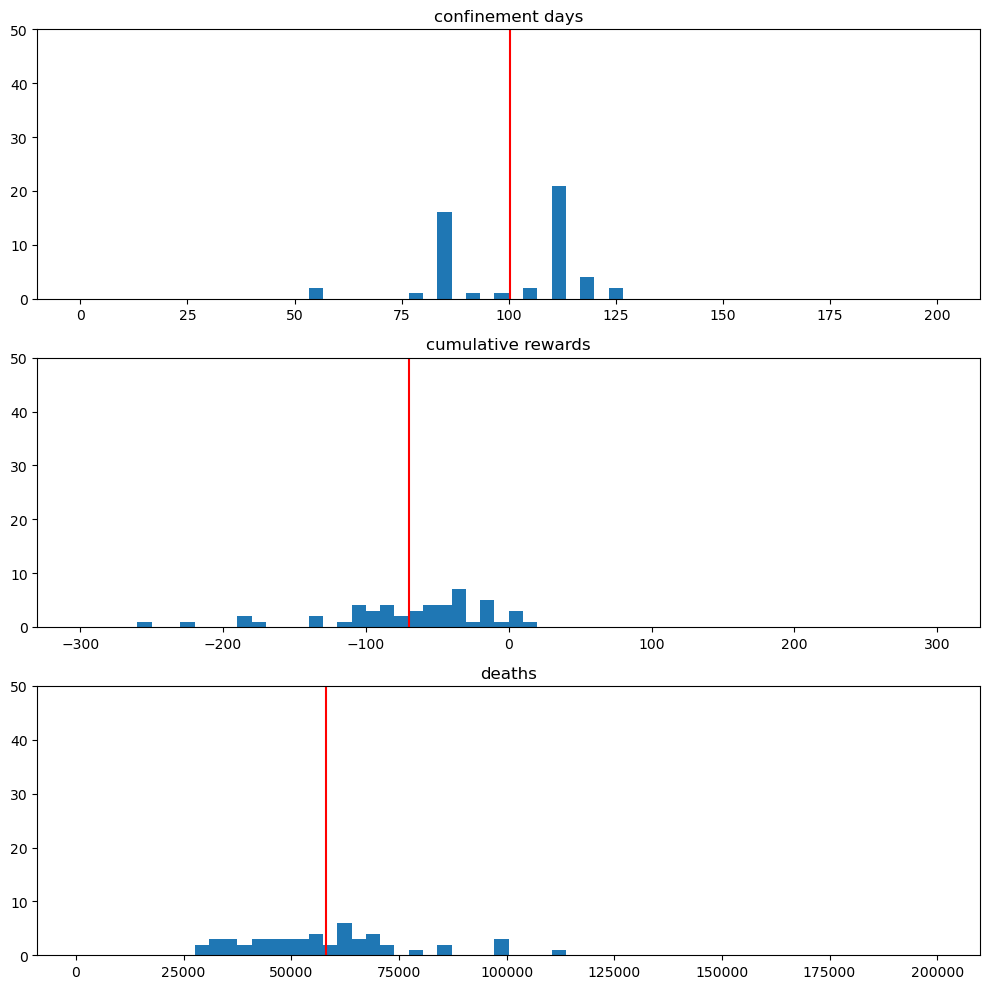

Average death number: 58071.94
Average number of confined days: 100.24
Average cumulative reward: -69.96264824778075


In [12]:
from utils import *

russo_env = Env(dyn,
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor_Russo)
russo_agent = RussoAgent(env)

episodes_features = eval_procedure(russo_agent, russo_env)

plot_episodes_features(episodes_features)

## Part 3: A Deep Q-learning approach


#### Question 3.a

##### Training

In [39]:
from DQN import *
action_space=spaces.Discrete(2)
dyn = ModelDynamics('config/switzerland.yaml')
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)


env = Env(dyn,
            action_space = action_space,
            observation_space= observation_space,
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor_DQN)

DQNagents = [DQNAgent(env) for _ in range(1)] #three agents
training_traces = []
eval_traces = []

for i,DQNag in enumerate(DQNagents) : #three training processes
    training_trace, eval_trace  = training_loop(env, DQNag, savepath= f"models/DQNparam{i+1}" ,first_seed= (i+1)*1000)
    training_traces.append(training_trace)
    eval_traces.append(eval_trace)


  7%|▋         | 34/500 [00:53<12:15,  1.58s/it] 


KeyboardInterrupt: 

##### Plotting

In [14]:
from utils import plot_training

plot_training(training_traces, eval_traces)


IndexError: list index out of range

##### Looking at the policy

In [15]:
best_evals = np.max(eval_traces, 1)
best_agent_idx = np.argmax(best_evals)
print(f"The best is agent {best_agent_idx +1}")

AxisError: axis 1 is out of bounds for array of dimension 1

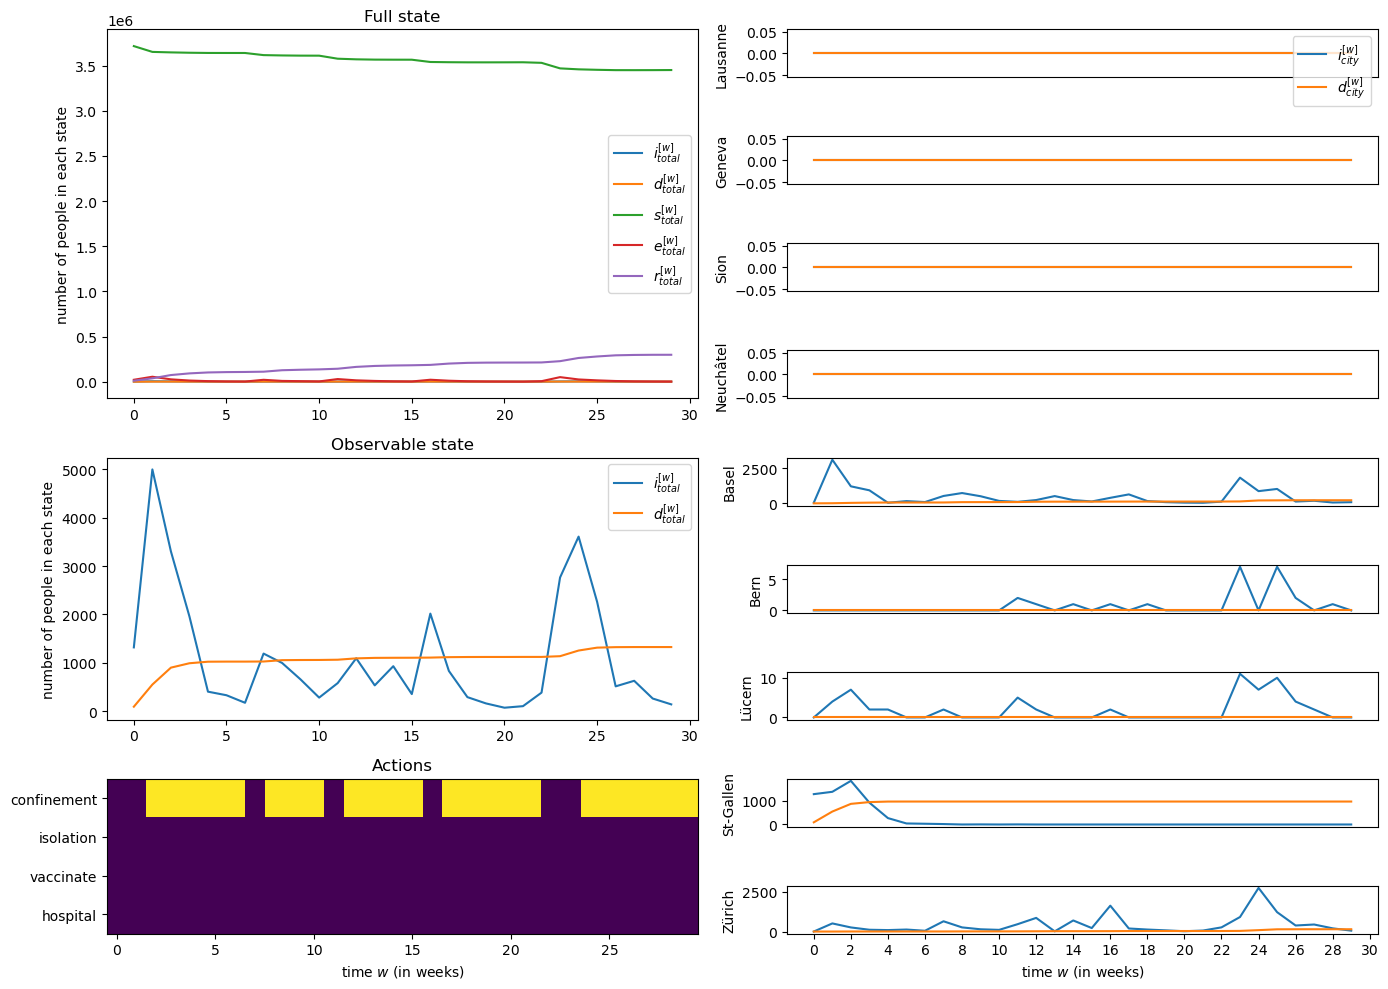

In [16]:
best_DQNagent = DQNAgent(env) #only for eval
best_DQNagent.load_model("models/DQNparam1.pth")

three_episodes = [run_episode(best_DQNagent, env, 100*i) for i in range(3)]
plot_episode(three_episodes[0][0], dyn, True)

#### Question 3.b

##### Training

In [17]:
from DQN import *
action_space=spaces.Discrete(2)
dyn = ModelDynamics('config/switzerland.yaml')
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)


env = Env(dyn,
            action_space = action_space,
            observation_space= observation_space,
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor_DQN)

DQNdecay_agents = [DQNAgent(env, eps_min= 0.2) for _ in range(3)] #three agents with eps decay
decay_training_traces = []
decay_eval_traces = []

for i,DQNag in enumerate(DQNdecay_agents) : #three training processes
    training_trace, eval_trace  = training_loop(env, DQNag, savepath= f"models/DQNdecay_param{i+1}" ,first_seed= (i+1)*1000)
    decay_training_traces.append(training_trace)
    decay_eval_traces.append(eval_trace)


  0%|          | 0/500 [00:06<?, ?it/s]


KeyboardInterrupt: 

##### Plotting

In [18]:
from utils import plot_training

plot_training(decay_training_traces, decay_eval_traces)


IndexError: list index out of range

#### Question 3.c 

In [19]:
from DQN import *
DQNaction_space=spaces.Discrete(2)
dyn = ModelDynamics('config/switzerland.yaml')
DQNobservation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)


DQNenv = Env(dyn,
            action_space = DQNaction_space,
            observation_space= DQNobservation_space,
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor_DQN)

best_DQNagent = DQNAgent(DQNenv, eps_0=0.0) #only for eval
best_DQNagent.load_model("models/DQNparam1.pth")

100%|██████████| 50/50 [00:40<00:00,  1.23it/s]


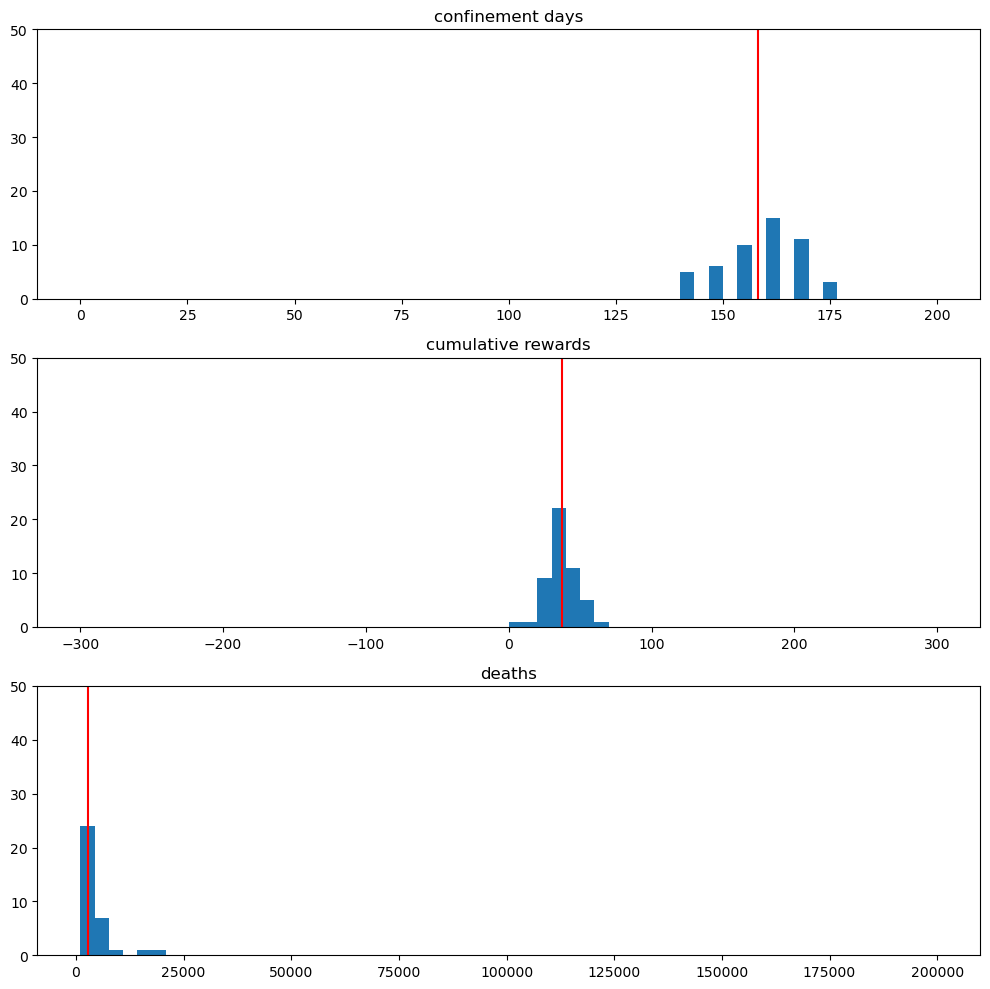

Average death number: 2706.56
Average number of confined days: 158.2
Average cumulative reward: 37.17053986826912


In [20]:
episode_features = eval_procedure(best_DQNagent,DQNenv)

#seed_sequence = np.arange(0,50)
#progress_bar = tqdm(total=seed_sequence[-1], unit="iteration")

#episodes_features = {"conf_days": [], "cumulative_rwd": [], "deaths": []}
#for i in seed_sequence:    
#    log, rwds = run_episode(best_DQNagent, env, i)
#    episode_feature = extract_episode_features(log, rwds)
#    for j, key in enumerate(episodes_features.keys()):
#        episodes_features[key].append(episode_feature[j])
#    progress_bar.update(1)
plot_episodes_features(episode_features)
#progress_bar.close()

Comparing with the professor's policy, we see that our best DQN policy is more efficient in reducing the number of deaths. Indeed, the DQN policy reduces the number of deaths by 55'000 people in average compared to the professor's policy case, it represents a reduction of 95% in average which is remarkable. A part from this we have a positive average reward of 37 while the professor's policy had an average reward of -69. The DQN policy is then more efficient in reducing the number of deaths and in keeping the economy running. The only drawback is the increased number of confined days which is higher in the DQN policy case. 

## Part4: Dealing with a more complex action Space

### Question 4.1 Toggle-action-space multi-action agent

#### Question 4.1.a
The action-observation space is now representing the change to the system we want to make. It is not about how the agent intervene in the system. It is how the agent wants to change rules in the system. The Q-value is now a 1D boolean array of size 5.

In a dynamical environment like this one, the optimal action changes over time. The agent has to adapt to the environment. Instead of having fixed actions with specific changes, the toggle action space is more flexible and allows higher maneuverability of the system.

However, this affects the network architecture which takes a more complex input. The input now also includes the state of the actions in addition to the state of the system. This implies that the network must be designed to accommodate these more complex preprocessors, which require additional layers and modifications to handle the augmented input.

Training with the action-observation space introduces a new challenge in learning the Q-values. The Q-values of toggle actions are dependent on the current state of each action, which means they can change dynamically during training. This introduces additional complexity in estimating accurate Q-values. The agent needs to learn not only the optimal Q-value for a given action but also how the state of that action affects its Q-value. This can lead to a more challenging training process, requiring longer training times and potentially more complex algorithms to converge to optimal policies.

#### Question 4.1.b

##### Training

In [21]:
from toggle import *

toggle_observation_space = spaces.Box( low=0,
                                    high=1,
                                    shape=(6, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)

toggle_env = Env(dyn,
            action_space = toggle_action_space,
            observation_space= toggle_observation_space,
            action_preprocessor= toggle_action_preprocessor,
            observation_preprocessor= toggle_observation_preprocessor)

DQNtoggle_agents = [DQNAgent(toggle_env, eps_min= 0.2, lr = 10e-5) for _ in range(3)] #three toggle agents with eps decay
toggle_training_traces = []
toggle_eval_traces = []

for i,DQNag in enumerate(DQNtoggle_agents) : #three training processes
    training_trace, eval_trace  = training_loop(toggle_env, DQNag, savepath= f"models/DQNtoggle_param{i+1}" ,first_seed= (i+1)*1000)
    toggle_training_traces.append(training_trace)
    toggle_eval_traces.append(eval_trace)


  0%|          | 0/500 [00:02<?, ?it/s]


KeyboardInterrupt: 

##### Plotting

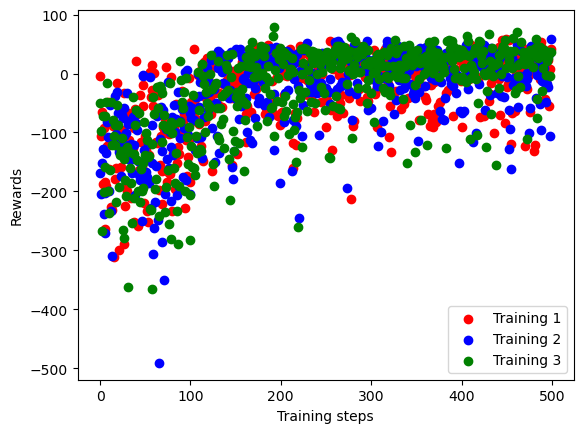

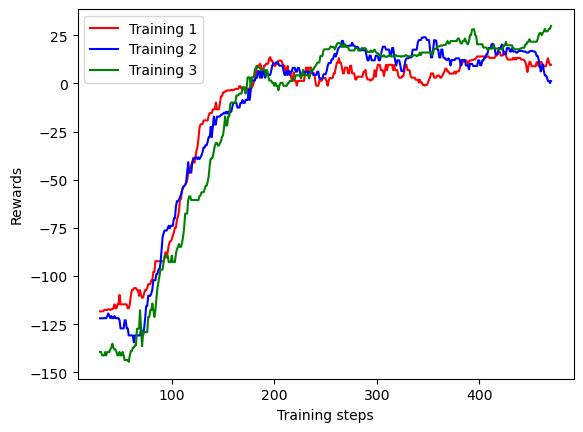

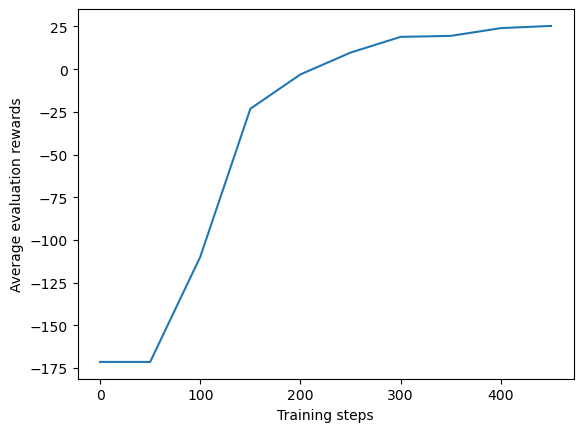

In [ ]:
plot_training(toggle_training_traces, toggle_eval_traces)

##### Looking at the policy

In [22]:
toggle_best_evals = np.max(toggle_eval_traces, 1)
toggle_best_agent_idx = np.argmax(best_evals)
print(f"The best is agent {best_agent_idx +1}")

AxisError: axis 1 is out of bounds for array of dimension 1

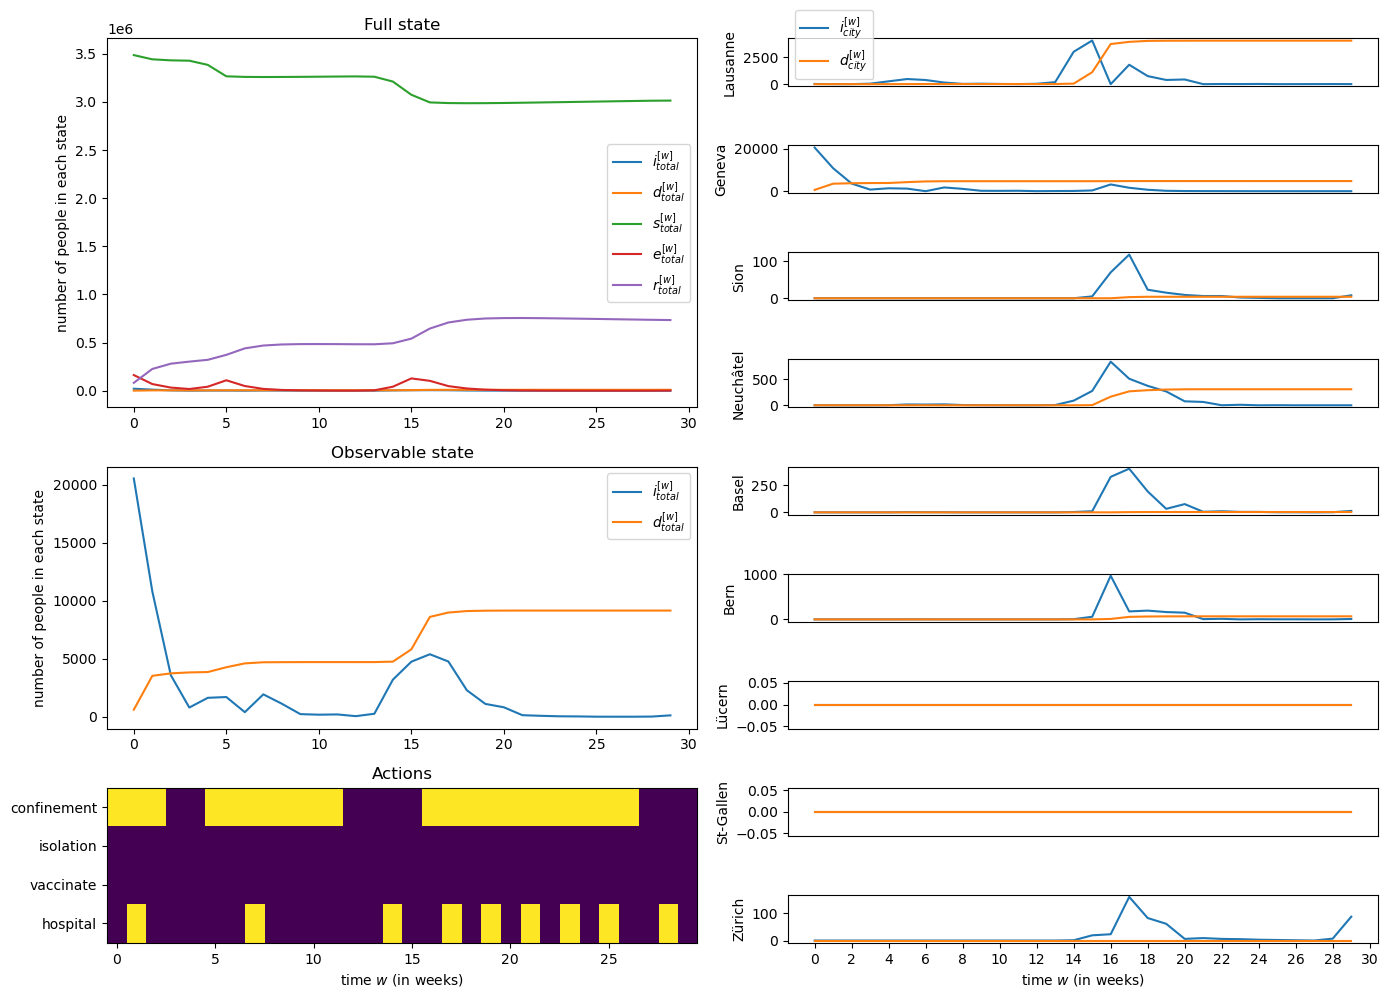

In [23]:

best_DQNtoggle_agent = DQNAgent(toggle_env) ###only for eval
best_DQNtoggle_agent.load_model("models/DQNtoggle_param1.pth")

three_episodes = [run_episode(best_DQNtoggle_agent, toggle_env, 100*i) for i in range(3)]
plot_episode(three_episodes[1][0], dyn, True)

#### Question 4.1.c

100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


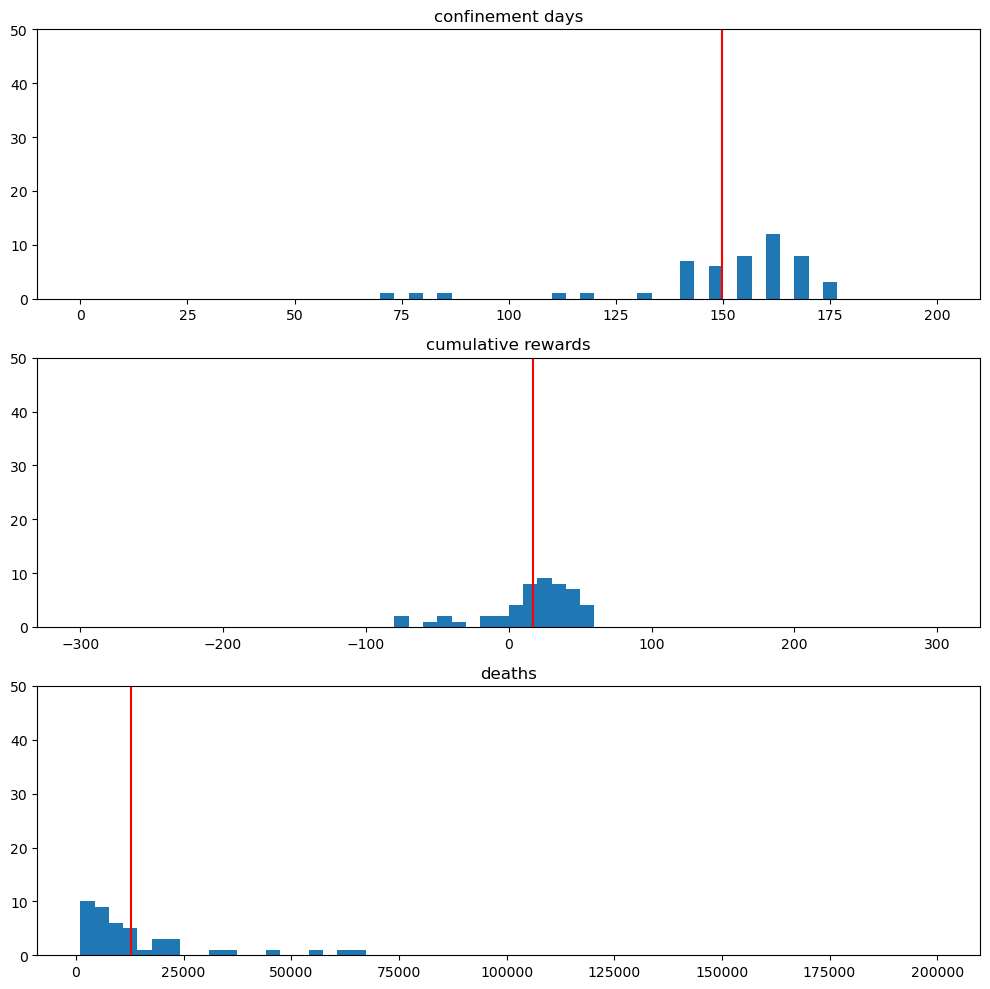

Average death number: 12656.34
Average number of confined days: 149.8
Average cumulative reward: 16.660592730583158


In [24]:
from toggle import *

toggle_env = Env(dyn,
            action_space = toggle_action_space,
            observation_space= toggle_observation_space,
            action_preprocessor= toggle_action_preprocessor,
            observation_preprocessor= toggle_observation_preprocessor)

best_DQNtoggle_agent = DQNAgent(toggle_env, eps_0= 0.0) ###only for eval
best_DQNtoggle_agent.load_model("models/DQNtoggle_param1.pth")

DQNtoggle_episodes_features = eval_procedure(best_DQNtoggle_agent, toggle_env)

plot_episodes_features(DQNtoggle_episodes_features)

#### Question 4.1.d
The assumption made in the toggle action space is the fact that the actions are binary, or with a fixed number to the least. However, actions with continuous values would not be fitted for the toggle space. For instance, one could vaccinate people from a certain age range which would not be possible with the toggle action space because it would add a very high number of possible actions for all possible age ranges. More complex continuous type of actions could be thought of, but the general idea is that transforming it into a binary action would not be possible.

### 4.2 Factorized Q-values, multi-action agent

#### Question 4.2.a

#### Training

In [109]:
from DQN import *
from factorized import *
factorized_action_space = spaces.MultiBinary(4)
dyn = ModelDynamics('config/switzerland.yaml')
factorized_observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)

env = Env(dyn,
            action_space = factorized_action_space,
            observation_space= factorized_observation_space,
            action_preprocessor=DQN_action_preprocessor_factorized,
            observation_preprocessor=DQN_observation_preprocessor_factorized)

DQNfactorized_agents = [DQN_factorizedAgent(env, eps_min= 0.2, lr=7.0e-5) for _ in range(1)] #three agents with eps decay
Factorized_training_traces = []
Factorized_eval_traces = []

for i,DQNag in enumerate(DQNfactorized_agents) : #three training processes
    training_trace, eval_trace  = training_loop(env, DQNag, savepath= f"models/DQNfactorized_param{i+1}" ,first_seed= (i+1)*1000, Tmax=500)
    Factorized_training_traces.append(training_trace)
    Factorized_eval_traces.append(eval_trace)


100%|██████████| 500/500 [14:24<00:00,  1.73s/it]


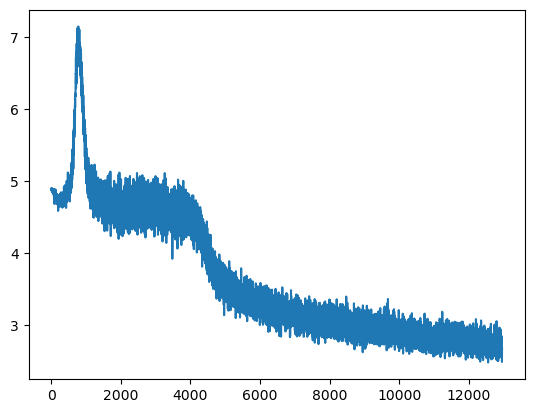

In [110]:
plt.plot(DQNfactorized_agents[0].losses)

#### Plotting

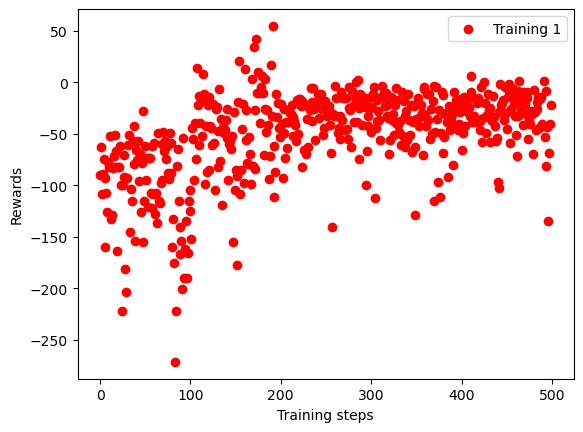

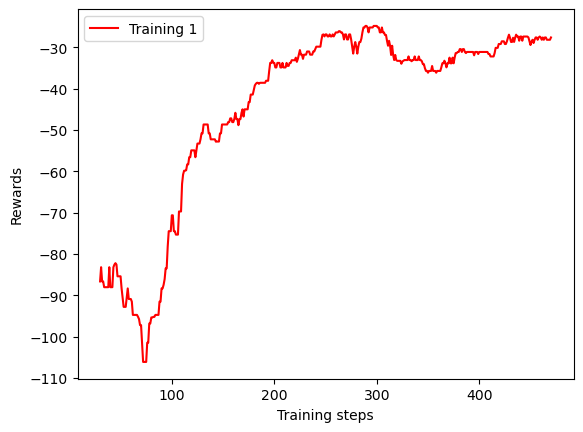

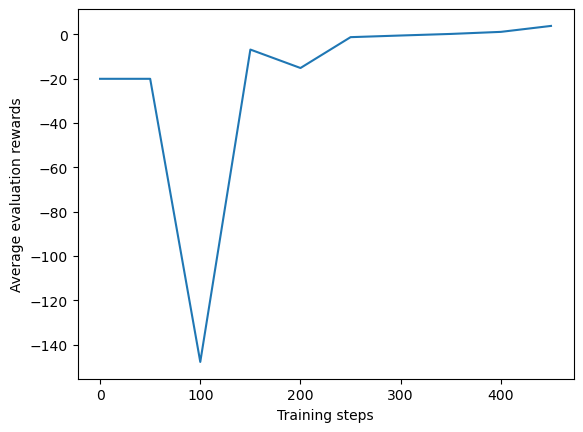

In [111]:
plot_training(Factorized_training_traces, Factorized_eval_traces)

#### Question 4.2.b

## Part5: Wrapping Up

#### Question 5.a

#### Question 5.b

#### Question 5.c